# NER for constructing KG

In [3]:
!pip install spacy datasets scikit-learn sklearn_crfsuite networkx
!python -m spacy download en_core_web_sm

  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached sklearn_crfsuite-0.5.0-py2.py3-none-any.whl.metadata (4.9 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from datasets import load_dataset
from sklearn_crfsuite import CRF
from sklearn.metrics import classification_report, confusion_matrix, f1_score

## EDA and preprocessing CoNLLu04


In this experiment will be used [CoNLLU04 dataset](https://huggingface.co/datasets/DFKI-SLT/conll04) which contains extracted named entities (ORG, LOC, PER, MISC), their relations (Located_In, Work_For, OrgBased_In, Live_In, Kill), and corresponding texts. The data is primarily based on news articles. The original dataset can be found [here](https://cogcomp.seas.upenn.edu/page/resource_view/43)

In [5]:
dataset = load_dataset("DFKI-SLT/conll04")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.21k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/118k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/40.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/46.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/922 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/231 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/288 [00:00<?, ? examples/s]

The dataset has already contained data for training, validation and testing. Let's convert all JSON data in DataFrame.

In [6]:
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()
df_train.head()

,entities,tokens,relations,orig_id
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210


The dataset does not contain NaNs, all columns (instead of unique id) are of object data type.

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   entities   922 non-null    object
 1   tokens     922 non-null    object
 2   relations  922 non-null    object
 3   orig_id    922 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 28.9+ KB


Let's provide basic statistics

In [8]:
print("Training samples:", len(df_train))
print("Test samples:", len(df_test))

Training samples: 922
Test samples: 288


#### Texts and tokens

In [9]:
df_train["texts"] = df_train["tokens"].apply(lambda x: " ".join(x))
df_test["texts"] = df_test["tokens"].apply(lambda x: " ".join(x))
df_train.head()

,entities,tokens,relations,orig_id,texts
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t..."
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...


Examples of texts

In [10]:
for i in df_train['texts'].head(5):
  print(i)

Newspaper ` Explains ' U.S. Interests Section Events FL1402001894 Havana Radio Reloj Network in Spanish 2100 GMT 13 Feb 94
` ` If it does not snow , and a lot , within this month we will have no water to submerge 150 , 000 hectares ( 370 , 500 acres ) of rice , ' ' said Bruno Pusterla , a top official of the Italian Agricultural Confederation .
The self-propelled rig Avco 5 was headed to shore with 14 people aboard early Monday when it capsized about 20 miles off the Louisiana coast , near Morgan City , Lifa said.
Annie Oakley , also known as Little Miss Sure Shot , was born Phoebe Ann Moses in Willowdell , Darke County , in 1860 .
Penry raped Pamela Moseley Carpenter on Oct. 15 , 1979 , in Livingston , Texas , then stabbed her to death .


Plot token count distribution

Total Tokens: 26525
Average Tokens Per Row: 28.77


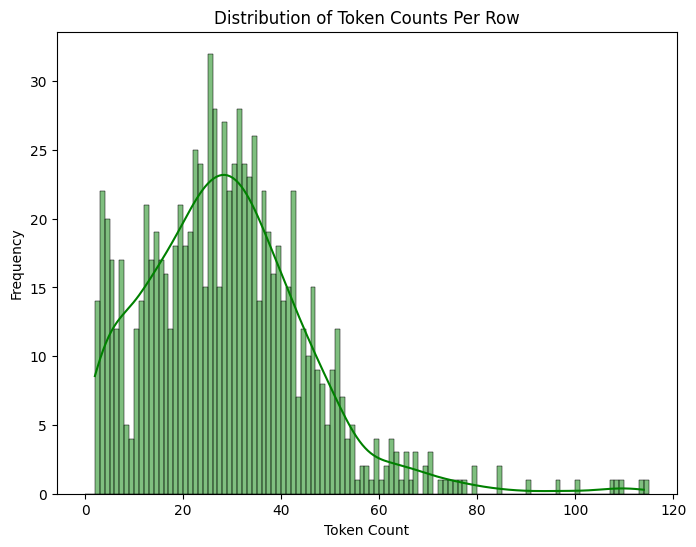

In [11]:
token_counts = [len(tokens) for tokens in df_train['tokens']]
total_tokens = sum(token_counts)
average_token_length = sum(token_counts) / len(token_counts)

print(f"Total Tokens: {total_tokens}")
print(f"Average Tokens Per Row: {average_token_length:.2f}")

plt.figure(figsize=(8, 6))
sns.histplot(token_counts, bins=range(0, max(token_counts) + 2), kde=True, color='green')
plt.title('Distribution of Token Counts Per Row')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

Total Characters: 143962
Average Characters Per Row: 156.14


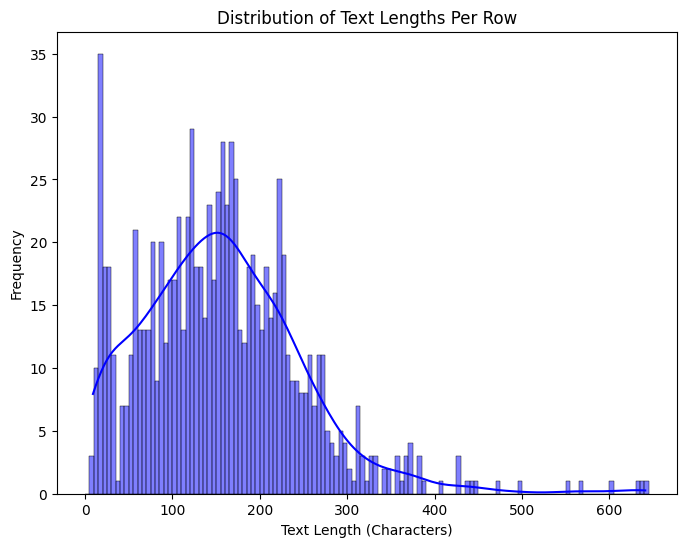

In [12]:
text_lengths = [len(text) for text in df_train['texts']]
total_text_length = sum(text_lengths)
average_text_length = sum(text_lengths) / len(text_lengths)

print(f"Total Characters: {total_text_length}")
print(f"Average Characters Per Row: {average_text_length:.2f}")

plt.figure(figsize=(8, 6))
sns.histplot(text_lengths, bins=range(0, max(text_lengths) + 5, 5), kde=True, color='blue')
plt.title('Distribution of Text Lengths Per Row')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')
plt.show()

#### Entities

In [13]:
def create_named_entities(entities, tokens):
    named_entities = []
    for entity in entities:
        start = entity['start']
        end = entity['end']
        entity_type = entity['type']
        entity_text = ' '.join(tokens[start:end])
        entry = f"{entity_text} ({start}, {end}) : {entity_type}"
        named_entities.append(entry)
    return named_entities

In [14]:
df_train['named_entities'] = df_train.apply(lambda row: create_named_entities(row['entities'], row['tokens']), axis=1)
df_train

,entities,tokens,relations,orig_id,texts,named_entities
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi..."
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t...","[150 , 000 hectares (22, 26) : Other, 370 , 50..."
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...,"[20 miles (19, 21) : Other, Louisiana (23, 24)..."
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ...","[Annie Oakley (0, 2) : Peop, Little Miss Sure ..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter..."
...,...,...,...,...,...,...
917,"[{'end': 1, 'start': 0, 'type': 'Other'}, {'en...","[An-a-one, ,, an-a-two, ,, an-a-three, billion...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}]",5423,"An-a-one , an-a-two , an-a-three billion ) Tax...","[An-a-one (0, 1) : Other, Lawrence Welk (18, 2..."
918,"[{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...","[Another, GE, employee, ,, attorney, Robert, C...","[{'head': 1, 'tail': 0, 'type': 'Work_For'}]",1269,"Another GE employee , attorney Robert C. Ander...","[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ..."
919,"[{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...","[(, Text, ), Following, the, conclusion, of, t...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...",4136,( Text ) Following the conclusion of the Genev...,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe..."
920,"[{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...","[Eaglebrook, East, opened, in, Middletown, in,...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",1452,Eaglebrook East opened in Middletown in April .,"[Eaglebrook East (0, 2) : Org, Middletown (4, ..."


In [15]:
def categorize_entities(entities_list):
    categories = {'Peop': 0, 'Loc': 0, 'Org': 0, 'Other': 0}
    for entity_str in entities_list:
        parts = entity_str.split(': ')
        if len(parts) >= 2:
            entity_type = parts[1].strip()
            if entity_type in categories:
                categories[entity_type] += 1
    return categories

In [16]:
train_ent = df_train[['orig_id', 'named_entities']]
train_ent['entity_categories'] = train_ent['named_entities'].apply(categorize_entities)
train_ent

<ipython-input-16-1b412a188198>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ent['entity_categories'] = train_ent['named_entities'].apply(categorize_entities)


,orig_id,named_entities,entity_categories
0,3255,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...","{'Peop': 0, 'Loc': 2, 'Org': 1, 'Other': 2}"
1,95,"[150 , 000 hectares (22, 26) : Other, 370 , 50...","{'Peop': 1, 'Loc': 0, 'Org': 1, 'Other': 3}"
2,2447,"[20 miles (19, 21) : Other, Louisiana (23, 24)...","{'Peop': 1, 'Loc': 2, 'Org': 0, 'Other': 1}"
3,5284,"[Annie Oakley (0, 2) : Peop, Little Miss Sure ...","{'Peop': 3, 'Loc': 1, 'Org': 0, 'Other': 0}"
4,210,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter...","{'Peop': 2, 'Loc': 2, 'Org': 0, 'Other': 1}"
...,...,...,...
917,5423,"[An-a-one (0, 1) : Other, Lawrence Welk (18, 2...","{'Peop': 1, 'Loc': 1, 'Org': 1, 'Other': 1}"
918,1269,"[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...","{'Peop': 1, 'Loc': 0, 'Org': 1, 'Other': 0}"
919,4136,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...","{'Peop': 1, 'Loc': 2, 'Org': 1, 'Other': 0}"
920,1452,"[Eaglebrook East (0, 2) : Org, Middletown (4, ...","{'Peop': 0, 'Loc': 1, 'Org': 1, 'Other': 0}"


In [17]:
categories = ['Peop', 'Loc', 'Org', 'Other']

encoded_ent = train_ent['entity_categories'].apply(
    lambda x: {cat: x.get(cat, 0) for cat in categories}
).apply(pd.Series)

encoded_ent = pd.concat(
    [train_ent[['orig_id']], encoded_ent],
    axis=1
)

encoded_ent

,orig_id,Peop,Loc,Org,Other
0,3255,0,2,1,2
1,95,1,0,1,3
2,2447,1,2,0,1
3,5284,3,1,0,0
4,210,2,2,0,1
...,...,...,...,...,...
917,5423,1,1,1,1
918,1269,1,0,1,0
919,4136,1,2,1,0
920,1452,0,1,1,0


Plot a bar chart

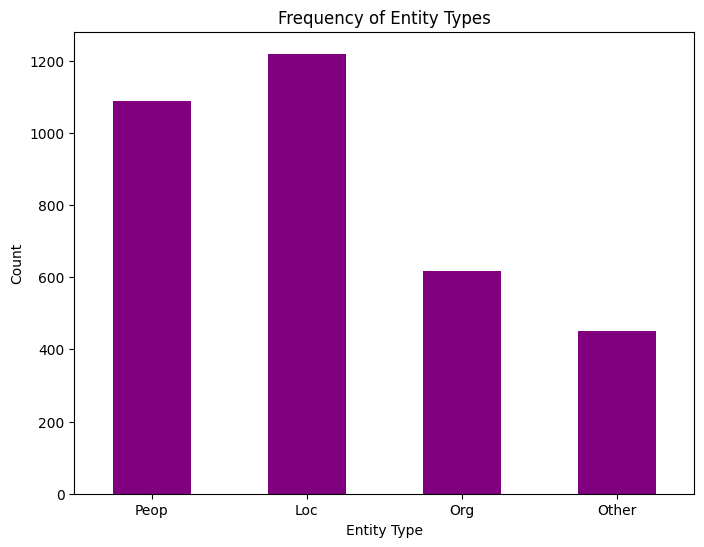

In [18]:
entity_counts = encoded_ent[['Peop', 'Loc', 'Org', 'Other']].sum()

plt.figure(figsize=(8, 6))
entity_counts.plot(kind='bar', color=['purple'])
plt.title('Frequency of Entity Types')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

#### Relations

Let's analyze unique relations

In [19]:
def create_triplets(relations, named_entities):
    triplets = []
    for relation in relations:
        head_idx = relation['head']
        tail_idx = relation['tail']
        rel_type = relation['type']

        head_entity_str = named_entities[head_idx]
        tail_entity_str = named_entities[tail_idx]


        head_entity_type = head_entity_str.split(':')[-1].strip()
        tail_entity_type = tail_entity_str.split(':')[-1].strip()

        # create the triplet using only the types of entities
        triplet = f"{head_entity_type}|{rel_type}|{tail_entity_type}"
        triplets.append(triplet)
    return triplets

In [20]:
df_train['triplets'] = df_train.apply(lambda row: create_triplets(row['relations'], row['named_entities']), axis=1)
df_train

,entities,tokens,relations,orig_id,texts,named_entities,triplets
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...",[Org|OrgBased_In|Loc]
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t...","[150 , 000 hectares (22, 26) : Other, 370 , 50...",[Peop|Work_For|Org]
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...,"[20 miles (19, 21) : Other, Louisiana (23, 24)...",[Loc|Located_In|Loc]
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ...","[Annie Oakley (0, 2) : Peop, Little Miss Sure ...","[Peop|Live_In|Loc, Peop|Live_In|Loc, Peop|Live..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter...",[Loc|Located_In|Loc]
...,...,...,...,...,...,...,...
917,"[{'end': 1, 'start': 0, 'type': 'Other'}, {'en...","[An-a-one, ,, an-a-two, ,, an-a-three, billion...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}]",5423,"An-a-one , an-a-two , an-a-three billion ) Tax...","[An-a-one (0, 1) : Other, Lawrence Welk (18, 2...",[Peop|Live_In|Loc]
918,"[{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...","[Another, GE, employee, ,, attorney, Robert, C...","[{'head': 1, 'tail': 0, 'type': 'Work_For'}]",1269,"Another GE employee , attorney Robert C. Ander...","[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...",[Peop|Work_For|Org]
919,"[{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...","[(, Text, ), Following, the, conclusion, of, t...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...",4136,( Text ) Following the conclusion of the Genev...,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...","[Peop|Live_In|Loc, Org|OrgBased_In|Loc]"
920,"[{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...","[Eaglebrook, East, opened, in, Middletown, in,...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",1452,Eaglebrook East opened in Middletown in April .,"[Eaglebrook East (0, 2) : Org, Middletown (4, ...",[Org|OrgBased_In|Loc]


In [21]:
unique_triplets = set()

for triplet_list in df_train['triplets']:
    if isinstance(triplet_list, list):
        for triplet in triplet_list:
            unique_triplets.add(triplet)

unique_triplets_list = list(unique_triplets)
unique_triplets_list

['Peop|Work_For|Org',
 'Org|OrgBased_In|Loc',
 'Peop|Live_In|Loc',
 'Peop|Kill|Peop',
 'Loc|Located_In|Loc']

#### Triplets

So let's visualize a distribution of triplets each row

In [22]:
df_train['triplet_count'] = df_train['triplets'].apply(len)
df_train

,entities,tokens,relations,orig_id,texts,named_entities,triplets,triplet_count
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...",[Org|OrgBased_In|Loc],1
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t...","[150 , 000 hectares (22, 26) : Other, 370 , 50...",[Peop|Work_For|Org],1
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...,"[20 miles (19, 21) : Other, Louisiana (23, 24)...",[Loc|Located_In|Loc],1
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ...","[Annie Oakley (0, 2) : Peop, Little Miss Sure ...","[Peop|Live_In|Loc, Peop|Live_In|Loc, Peop|Live...",3
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter...",[Loc|Located_In|Loc],1
...,...,...,...,...,...,...,...,...
917,"[{'end': 1, 'start': 0, 'type': 'Other'}, {'en...","[An-a-one, ,, an-a-two, ,, an-a-three, billion...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}]",5423,"An-a-one , an-a-two , an-a-three billion ) Tax...","[An-a-one (0, 1) : Other, Lawrence Welk (18, 2...",[Peop|Live_In|Loc],1
918,"[{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...","[Another, GE, employee, ,, attorney, Robert, C...","[{'head': 1, 'tail': 0, 'type': 'Work_For'}]",1269,"Another GE employee , attorney Robert C. Ander...","[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...",[Peop|Work_For|Org],1
919,"[{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...","[(, Text, ), Following, the, conclusion, of, t...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...",4136,( Text ) Following the conclusion of the Genev...,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...","[Peop|Live_In|Loc, Org|OrgBased_In|Loc]",2
920,"[{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...","[Eaglebrook, East, opened, in, Middletown, in,...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",1452,Eaglebrook East opened in Middletown in April .,"[Eaglebrook East (0, 2) : Org, Middletown (4, ...",[Org|OrgBased_In|Loc],1


In [23]:
#triplet_count for test
df_test['named_entities'] = df_test.apply(lambda row: create_named_entities(row['entities'], row['tokens']), axis=1)
df_test['triplets'] = df_test.apply(lambda row: create_triplets(row['relations'], row['named_entities']), axis=1)
df_test['triplet_count'] = df_test['triplets'].apply(len)
df_test

,entities,tokens,relations,orig_id,texts,named_entities,triplets,triplet_count
0,"[{'end': 7, 'start': 5, 'type': 'Org'}, {'end'...","[An, art, exhibit, at, the, Hakawati, Theatre,...","[{'head': 0, 'tail': 2, 'type': 'OrgBased_In'}]",17,An art exhibit at the Hakawati Theatre in Arab...,"[Hakawati Theatre (5, 7) : Org, Arab (8, 9) : ...",[Org|OrgBased_In|Loc],1
1,"[{'end': 1, 'start': 0, 'type': 'Loc'}, {'end'...","[PERUGIA, ,, Italy, (, AP, )]","[{'head': 0, 'tail': 1, 'type': 'Located_In'},...",23,"PERUGIA , Italy ( AP )","[PERUGIA (0, 1) : Loc, Italy (2, 3) : Loc, AP ...","[Loc|Located_In|Loc, Org|OrgBased_In|Loc, Org|...",3
2,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Reagan, sounded, positive, notes, reminiscent...","[{'head': 0, 'tail': 2, 'type': 'Live_In'}]",34,Reagan sounded positive notes reminiscent of e...,"[Reagan (0, 1) : Peop, American (26, 27) : Oth...",[Peop|Live_In|Loc],1
3,"[{'end': 16, 'start': 15, 'type': 'Org'}, {'en...","[There, was, no, mention, of, the, `, `, iron,...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",35,There was no mention of the ` ` iron triangle ...,"[Congress (15, 16) : Org, Washington (33, 34) ...",[Org|OrgBased_In|Loc],1
4,"[{'end': 16, 'start': 13, 'type': 'Org'}, {'en...","[Nor, did, he, argue, ,, as, he, did, in, a, s...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",36,"Nor did he argue , as he did in a speech at th...","[University of Virginia (13, 16) : Org, Charlo...",[Org|OrgBased_In|Loc],1
...,...,...,...,...,...,...,...,...
283,"[{'end': 1, 'start': 0, 'type': 'Other'}, {'en...","[Photo, ,, COLOR, ,, The, father, of, our, 34t...","[{'head': 2, 'tail': 4, 'type': 'Live_In'}]",5402,"Photo , COLOR , The father of our 34th Preside...","[Photo (0, 1) : Other, COLOR (2, 3) : Other, D...",[Peop|Live_In|Loc],1
284,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Bette, Davis, was, born, Ruth, Elizabeth, Dav...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5408,Bette Davis was born Ruth Elizabeth Davis on A...,"[Bette Davis (0, 2) : Peop, Ruth Elizabeth Dav...","[Peop|Live_In|Loc, Peop|Live_In|Loc]",2
285,"[{'end': 2, 'start': 1, 'type': 'Other'}, {'en...","[On, Oct., 18, ,, 1921, ,, Jesse, Alexander, H...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}]",5410,"On Oct. 18 , 1921 , Jesse Alexander Helms Jr. ...","[Oct. (1, 2) : Other, Jesse Alexander Helms Jr...",[Peop|Live_In|Loc],1
286,"[{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...","[The, House, voted, Thursday, to, withdraw, a,...","[{'head': 2, 'tail': 3, 'type': 'Live_In'}]",5413,The House voted Thursday to withdraw a grant t...,"[House (1, 2) : Org, Thursday (3, 4) : Other, ...",[Peop|Live_In|Loc],1


Plot the distribution of triplets

Total number of triplets in the dataset: 1283


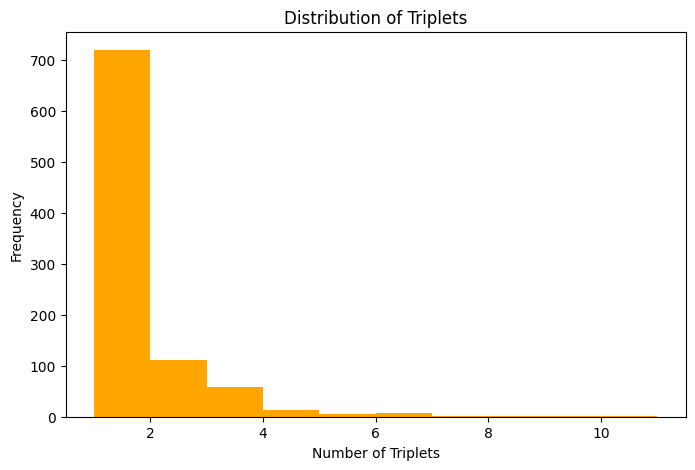

In [24]:
total_triplets = df_train['triplet_count'].sum()
print(f"Total number of triplets in the dataset: {total_triplets}")

plt.figure(figsize=(8, 5))
plt.hist(df_train['triplet_count'], bins=range(1, 12), color='orange')
plt.title("Distribution of Triplets")
plt.xlabel("Number of Triplets")
plt.ylabel("Frequency")
plt.show()

## Classical ML Method for NER task: Conditional Random Fields (CRF)

CRF is a discriminative probabilistic model designed for sequence labeling tasks like NER. Unlike generative models (e.g., Hidden Markov Models), CRFs directly model the conditional probability P(Y∣X), where Y is the label sequence and X is the input sequence. This allows CRFs to leverage complex feature interactions and avoid the label bias problem. More info about CRF: [[Lafferty et al.2001]](https://www.researchgate.net/publication/2529190_Conditional_Random_Fields_Probabilistic_Models_for_Segmenting_and_Labeling_Sequence_Data)

The conditional probability of a label sequence \( Y = (y_1, y_2, ..., y_n) \) given an input sequence \( X = (x_1, x_2, ..., x_n) \) is defined as:

$$P(Y|X; \theta) = \frac{1}{Z(X)} \exp \left( \sum_{i=1}^n \sum_k \theta_k^{(s)} f_k^{(s)}(y_i, x_i, i) + \sum_{i=1}^{n-1} \sum_k \theta_k^{(t)} f_k^{(t)}(y_i, y_{i+1}, x_i, x_{i+1}, i) \right)$$


Where:
- theta: Parameters (feature weights) learned during training
- Z(X): Normalization term (partition function), ensuring probabilities sum to 1
- f^(s): State (vertex) features which are associated with individual positions *i* and labels *y_i*
- f^(t): Transition (edge) features which are associated with transitions between labels *y_i* and *y_(i+1)*

In the experiment parameters from [this article](https://arxiv.org/pdf/1404.5367#page=3.43) was used:
- State features:
  - bias
  - POS
  - lower-case
  - its capitalization pattern;
  - whether it is punctuation
  - 4-character prefixes and suffixes;
  - character n-grams from length 2 to 5;

<b> + Neighborhood features </b>

- Transition features: bio-tagging tokens with named entities (features are specified through CRF model hyperparameters)

Let's modify current dataset and prepare data for training

### Extracting token features

In [25]:
nlp = spacy.load("en_core_web_sm")

In [26]:
def add_pos_tags(row):
    tokens = row['tokens']
    doc = nlp(' '.join(tokens))
    pos_tags = [token.pos_ for token in doc]

    row['pos_tags'] = pos_tags
    return row

In [27]:
df_train = df_train.apply(add_pos_tags, axis=1)
df_train

,entities,tokens,relations,orig_id,texts,named_entities,triplets,triplet_count,pos_tags
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...",[Org|OrgBased_In|Loc],1,"[NOUN, PUNCT, VERB, PUNCT, PROPN, PROPN, PROPN..."
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t...","[150 , 000 hectares (22, 26) : Other, 370 , 50...",[Peop|Work_For|Org],1,"[PUNCT, PUNCT, SCONJ, PRON, AUX, PART, VERB, P..."
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...,"[20 miles (19, 21) : Other, Louisiana (23, 24)...",[Loc|Located_In|Loc],1,"[DET, NOUN, PUNCT, VERB, NOUN, PROPN, NUM, AUX..."
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ...","[Annie Oakley (0, 2) : Peop, Little Miss Sure ...","[Peop|Live_In|Loc, Peop|Live_In|Loc, Peop|Live...",3,"[PROPN, PROPN, PUNCT, ADV, VERB, ADP, PROPN, P..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter...",[Loc|Located_In|Loc],1,"[PROPN, VERB, PROPN, PROPN, PROPN, ADP, PROPN,..."
...,...,...,...,...,...,...,...,...,...
917,"[{'end': 1, 'start': 0, 'type': 'Other'}, {'en...","[An-a-one, ,, an-a-two, ,, an-a-three, billion...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}]",5423,"An-a-one , an-a-two , an-a-three billion ) Tax...","[An-a-one (0, 1) : Other, Lawrence Welk (18, 2...",[Peop|Live_In|Loc],1,"[X, PUNCT, DET, PUNCT, NUM, PUNCT, DET, PUNCT,..."
918,"[{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...","[Another, GE, employee, ,, attorney, Robert, C...","[{'head': 1, 'tail': 0, 'type': 'Work_For'}]",1269,"Another GE employee , attorney Robert C. Ander...","[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...",[Peop|Work_For|Org],1,"[DET, PROPN, NOUN, PUNCT, NOUN, PROPN, PROPN, ..."
919,"[{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...","[(, Text, ), Following, the, conclusion, of, t...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...",4136,( Text ) Following the conclusion of the Genev...,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...","[Peop|Live_In|Loc, Org|OrgBased_In|Loc]",2,"[PUNCT, NOUN, PUNCT, VERB, DET, NOUN, ADP, DET..."
920,"[{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...","[Eaglebrook, East, opened, in, Middletown, in,...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",1452,Eaglebrook East opened in Middletown in April .,"[Eaglebrook East (0, 2) : Org, Middletown (4, ...",[Org|OrgBased_In|Loc],1,"[PROPN, PROPN, VERB, ADP, PROPN, ADP, PROPN, P..."


In [28]:
def get_char_ngrams(token, min_n=2, max_n=5):
    ngrams = set()
    for n in range(min_n, max_n+1):
        for i in range(len(token) - n + 1):
            ngrams.add(token[i:i+n])
    return ngrams

In [29]:
def extract_features(df_row, i):
    tokens = df_row['tokens']
    pos_tags = df_row['pos_tags']

    token = tokens[i]
    pos = pos_tags[i]

    features = {
        'bias': 1.0,
        'pos': pos,
        'word.lower()': token.lower(),
        'is_capitalized': token[0].isupper() if len(token) > 0 else False,
        'is_all_caps': token.isupper(),
        'word.is_punctuation': token in ['.', ',', ';', '?', '!'],
        'prefix4': token[:4] if len(token) >= 4 else token,
        'suffix4': token[-4:] if len(token) >= 4 else token,
        'char_ngrams': get_char_ngrams(token),
    }

    # Neighborhood features
    if i > 0:
        prev_token = tokens[i-1]
        prev_pos = pos_tags[i-1]
        features.update({
            '-1:word.lower()': prev_token.lower(),
            '-1:pos': prev_pos if len(prev_pos) >= 2 else prev_pos,
        })
    else:
        features['BOS'] = True

    if i < len(tokens) - 1:
        next_token = tokens[i+1]
        next_pos = pos_tags[i+1]
        features.update({
            '+1:word.lower()': next_token.lower(),
            '+1:pos': next_pos if len(next_pos) >= 2 else next_pos,
        })
    else:
        features['EOS'] = True

    return features

### BIO-tagging

In [30]:
def generate_bio_tags(tokens, entities):
    bio_tags = ['O'] * len(tokens)
    for entity in entities:
        start = entity['start']
        end = entity['end']
        typ = entity['type']
        if start < len(bio_tags):
            bio_tags[start] = f'B-{typ}'
        for i in range(start + 1, end):
            if i < len(bio_tags):
                bio_tags[i] = f'I-{typ}'
    return bio_tags

In [31]:
df_train['bio_tags'] = df_train.apply(lambda row: generate_bio_tags(row['tokens'], row['entities']), axis=1)
df_train

,entities,tokens,relations,orig_id,texts,named_entities,triplets,triplet_count,pos_tags,bio_tags
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...",[Org|OrgBased_In|Loc],1,"[NOUN, PUNCT, VERB, PUNCT, PROPN, PROPN, PROPN...","[O, O, O, O, B-Loc, O, O, O, O, B-Loc, B-Org, ..."
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t...","[150 , 000 hectares (22, 26) : Other, 370 , 50...",[Peop|Work_For|Org],1,"[PUNCT, PUNCT, SCONJ, PRON, AUX, PART, VERB, P...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...,"[20 miles (19, 21) : Other, Louisiana (23, 24)...",[Loc|Located_In|Loc],1,"[DET, NOUN, PUNCT, VERB, NOUN, PROPN, NUM, AUX...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ...","[Annie Oakley (0, 2) : Peop, Little Miss Sure ...","[Peop|Live_In|Loc, Peop|Live_In|Loc, Peop|Live...",3,"[PROPN, PROPN, PUNCT, ADV, VERB, ADP, PROPN, P...","[B-Peop, I-Peop, O, O, O, O, B-Peop, I-Peop, I..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter...",[Loc|Located_In|Loc],1,"[PROPN, VERB, PROPN, PROPN, PROPN, ADP, PROPN,...","[B-Peop, O, B-Peop, I-Peop, I-Peop, O, B-Other..."
...,...,...,...,...,...,...,...,...,...,...
917,"[{'end': 1, 'start': 0, 'type': 'Other'}, {'en...","[An-a-one, ,, an-a-two, ,, an-a-three, billion...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}]",5423,"An-a-one , an-a-two , an-a-three billion ) Tax...","[An-a-one (0, 1) : Other, Lawrence Welk (18, 2...",[Peop|Live_In|Loc],1,"[X, PUNCT, DET, PUNCT, NUM, PUNCT, DET, PUNCT,...","[B-Other, O, O, O, O, O, O, O, O, O, O, O, O, ..."
918,"[{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...","[Another, GE, employee, ,, attorney, Robert, C...","[{'head': 1, 'tail': 0, 'type': 'Work_For'}]",1269,"Another GE employee , attorney Robert C. Ander...","[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...",[Peop|Work_For|Org],1,"[DET, PROPN, NOUN, PUNCT, NOUN, PROPN, PROPN, ...","[O, B-Org, O, O, O, B-Peop, I-Peop, I-Peop, O,..."
919,"[{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...","[(, Text, ), Following, the, conclusion, of, t...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...",4136,( Text ) Following the conclusion of the Genev...,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...","[Peop|Live_In|Loc, Org|OrgBased_In|Loc]",2,"[PUNCT, NOUN, PUNCT, VERB, DET, NOUN, ADP, DET...","[O, O, O, O, O, O, O, O, B-Loc, O, O, O, B-Peo..."
920,"[{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...","[Eaglebrook, East, opened, in, Middletown, in,...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",1452,Eaglebrook East opened in Middletown in April .,"[Eaglebrook East (0, 2) : Org, Middletown (4, ...",[Org|OrgBased_In|Loc],1,"[PROPN, PROPN, VERB, ADP, PROPN, ADP, PROPN, P...","[B-Org, I-Org, O, O, B-Loc, O, O, O]"


## Training

In [32]:
def sent2features(df_row):
    tokens = df_row['tokens']
    return [extract_features(df_row, i) for i in range(len(tokens))]

def sent2labels(df_row):
    return df_row['bio_tags']

In [33]:
X_train = df_train.apply(sent2features, axis=1).tolist()
y_train = df_train.apply(sent2labels, axis=1).tolist()

In [34]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=50,
)

crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=50)

Let's preprocess test data for evaluating results

In [35]:
df_test['bio_tags'] = df_test.apply(lambda row: generate_bio_tags(row['tokens'], row['entities']), axis=1)
df_test = df_test.apply(add_pos_tags, axis=1)

In [36]:
X_test = df_test.apply(sent2features, axis=1).tolist()
y_test = df_test.apply(sent2labels, axis=1).tolist()

y_pred = crf.predict(X_test)

## Evaluating

In [37]:
y_test_flat = [label for sentence in y_test for label in sentence]
y_pred_flat = [label for sentence in y_pred for label in sentence]

labels = list(crf.classes_)


report_dict = classification_report(y_test_flat, y_pred_flat, labels=labels, digits=4, output_dict=True)

print("Classification Report:")
print(classification_report(y_test_flat, y_pred_flat, labels=labels, digits=4))

Classification Report:
              precision    recall  f1-score   support

           O     0.9692    0.9781    0.9737      6313
       B-Loc     0.8682    0.8173    0.8420       427
       B-Org     0.8045    0.7273    0.7639       198
       I-Org     0.6920    0.7925    0.7389       241
     B-Other     0.7981    0.6241    0.7004       133
     I-Other     0.8155    0.6462    0.7210       130
      B-Peop     0.8116    0.8318    0.8215       321
      I-Peop     0.8471    0.9458    0.8937       369
       I-Loc     0.8375    0.6569    0.7363       204

    accuracy                         0.9328      8336
   macro avg     0.8271    0.7800    0.7990      8336
weighted avg     0.9323    0.9328    0.9316      8336



In [38]:
micro_f1 = f1_score(y_test_flat, y_pred_flat, average='micro')

print(f"micro-F1: {micro_f1:.4f}")

micro-F1: 0.9328


Plot the confusion matrix

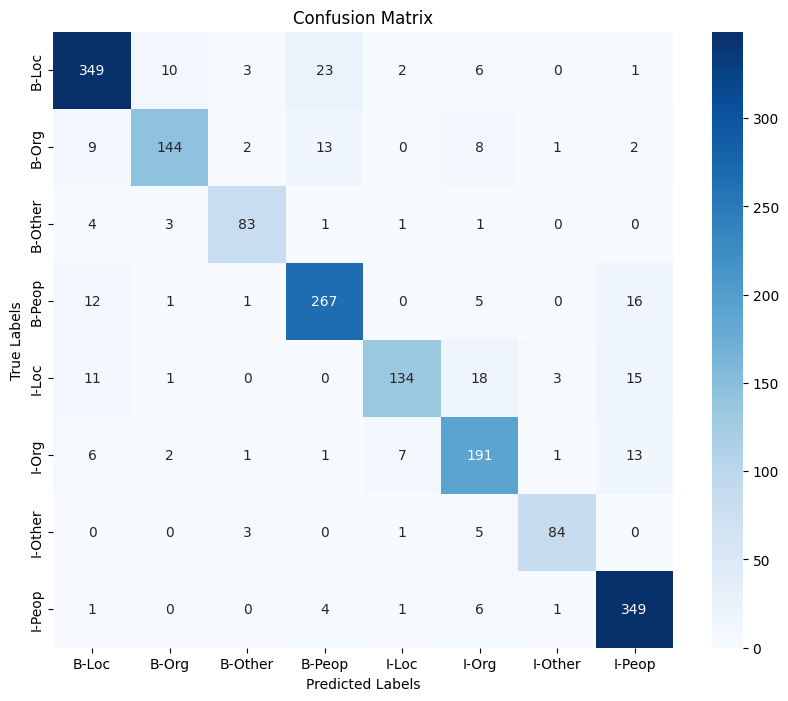

In [39]:
filtered_true = []
filtered_pred = []
for true_tag, pred_tag in zip(y_test_flat, y_pred_flat):
    if true_tag != 'O':
        filtered_true.append(true_tag)
        filtered_pred.append(pred_tag)

labels = list(set(tag for sent in y_test for tag in sent if tag != 'O'))
labels.sort()

cm = confusion_matrix(filtered_true, filtered_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Visualizing

Let's provide vizualization of extracted NERs

In [57]:
df_croped_test = df_test[df_test['triplet_count'] == 1] # only text with 1 triplet
df_croped_test = df_croped_test[['orig_id', 'texts', 'tokens', 'pos_tags', 'bio_tags']]

df_croped_test.head()

,orig_id,texts,tokens,pos_tags,bio_tags
0,17,An art exhibit at the Hakawati Theatre in Arab...,"[An, art, exhibit, at, the, Hakawati, Theatre,...","[DET, NOUN, NOUN, ADP, DET, PROPN, PROPN, ADP,...","[O, O, O, O, O, B-Org, I-Org, O, B-Other, O, B..."
2,34,Reagan sounded positive notes reminiscent of e...,"[Reagan, sounded, positive, notes, reminiscent...","[PROPN, VERB, ADJ, NOUN, ADJ, ADP, ADJ, NOUN, ...","[B-Peop, O, O, O, O, O, O, O, O, O, O, O, O, O..."
3,35,There was no mention of the ` ` iron triangle ...,"[There, was, no, mention, of, the, `, `, iron,...","[PRON, VERB, DET, NOUN, ADP, DET, PUNCT, PUNCT...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,36,"Nor did he argue , as he did in a speech at th...","[Nor, did, he, argue, ,, as, he, did, in, a, s...","[CCONJ, AUX, PRON, VERB, PUNCT, SCONJ, PRON, V...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-Org,..."
5,56,"Wright , a University of Texas law professor ,...","[Wright, ,, a, University, of, Texas, law, pro...","[PROPN, PUNCT, DET, PROPN, ADP, PROPN, NOUN, N...","[B-Peop, O, O, B-Org, I-Org, I-Org, O, O, O, O..."


Let's make predictions for test data and extract named entities from BIO-tags

In [58]:
X_croped_test = df_croped_test.apply(sent2features, axis=1).tolist()
y_pred_croped = crf.predict(X_croped_test)

df_croped_test["predicted_bio_tags"] = y_pred_croped
df_croped_test.head()

,orig_id,texts,tokens,pos_tags,bio_tags,predicted_bio_tags
0,17,An art exhibit at the Hakawati Theatre in Arab...,"[An, art, exhibit, at, the, Hakawati, Theatre,...","[DET, NOUN, NOUN, ADP, DET, PROPN, PROPN, ADP,...","[O, O, O, O, O, B-Org, I-Org, O, B-Other, O, B...","[O, O, O, O, O, B-Org, I-Org, O, B-Loc, O, B-L..."
2,34,Reagan sounded positive notes reminiscent of e...,"[Reagan, sounded, positive, notes, reminiscent...","[PROPN, VERB, ADJ, NOUN, ADJ, ADP, ADJ, NOUN, ...","[B-Peop, O, O, O, O, O, O, O, O, O, O, O, O, O...","[B-Peop, O, O, O, O, O, O, O, O, O, O, O, O, O..."
3,35,There was no mention of the ` ` iron triangle ...,"[There, was, no, mention, of, the, `, `, iron,...","[PRON, VERB, DET, NOUN, ADP, DET, PUNCT, PUNCT...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,36,"Nor did he argue , as he did in a speech at th...","[Nor, did, he, argue, ,, as, he, did, in, a, s...","[CCONJ, AUX, PRON, VERB, PUNCT, SCONJ, PRON, V...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-Org,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-Org,..."
5,56,"Wright , a University of Texas law professor ,...","[Wright, ,, a, University, of, Texas, law, pro...","[PROPN, PUNCT, DET, PROPN, ADP, PROPN, NOUN, N...","[B-Peop, O, O, B-Org, I-Org, I-Org, O, O, O, O...","[B-Peop, O, O, B-Org, I-Org, I-Org, O, O, O, O..."


In [59]:
def extract_entities(tokens, tags, valid_types={"Peop", "Org", "Loc"}):
    entities = []
    current_entity = None

    for idx, (token, tag) in enumerate(zip(tokens, tags)):
        if tag.startswith("B-"):
            entity_type = tag[2:]
            if entity_type in valid_types:
                # create new entity
                if current_entity:
                    entities.append(current_entity)
                current_entity = {
                    "text": token,
                    "type": entity_type,
                    "start": idx,
                    "end": idx + 1
                }
            else:
                # ignore 'Other' tag
                if current_entity:
                    entities.append(current_entity)
                current_entity = None
        elif tag.startswith("I-"):
            entity_type = tag[2:]
            if current_entity and current_entity["type"] == entity_type:
                # continuation of entity
                current_entity["text"] += " " + token
                current_entity["end"] += 1
            else:
                # ignore 'Other' tag
                if current_entity:
                    entities.append(current_entity)
                current_entity = None
        else:  # tag == "O"
            if current_entity:
                entities.append(current_entity)
            current_entity = None
    if current_entity:
        entities.append(current_entity)

    return entities

In [60]:
df_croped_test["predicted_entities"] = df_croped_test.apply(
    lambda row: extract_entities(row["tokens"], row["predicted_bio_tags"]),
    axis=1
)
df_croped_test = df_croped_test[df_croped_test['predicted_entities'].apply(lambda x: len(x) == 2)]
df_croped_test.head()

,orig_id,texts,tokens,pos_tags,bio_tags,predicted_bio_tags,predicted_entities
11,130,"Hot Springs National Park , Ark. ;","[Hot, Springs, National, Park, ,, Ark., ;]","[PROPN, PROPN, PROPN, PROPN, PUNCT, PROPN, PUNCT]","[B-Loc, I-Loc, I-Loc, I-Loc, O, B-Loc, O]","[B-Peop, I-Peop, I-Peop, I-Peop, O, B-Loc, O]","[{'text': 'Hot Springs National Park', 'type':..."
12,136,"Aguadilla , Puerto Rico ;","[Aguadilla, ,, Puerto, Rico, ;]","[PROPN, PUNCT, PROPN, PROPN, PUNCT]","[B-Loc, O, B-Loc, I-Loc, O]","[B-Loc, O, B-Loc, I-Loc, O]","[{'text': 'Aguadilla', 'type': 'Loc', 'start':..."
14,150,"ATLANTIC CITY , N.J .","[ATLANTIC, CITY, ,, N.J, .]","[PROPN, PROPN, PUNCT, PROPN, PUNCT]","[B-Loc, I-Loc, O, B-Loc, I-Loc]","[B-Loc, I-Loc, O, B-Loc, O]","[{'text': 'ATLANTIC CITY', 'type': 'Loc', 'sta..."
17,195,Boston University 's Michael D. Papagiannis sa...,"[Boston, University, 's, Michael, D., Papagian...","[PROPN, PROPN, PART, PROPN, PROPN, PROPN, VERB...","[B-Org, I-Org, O, B-Peop, I-Peop, I-Peop, O, O...","[B-Org, I-Org, O, B-Peop, I-Peop, I-Peop, O, O...","[{'text': 'Boston University', 'type': 'Org', ..."
19,198,"BONE , Idaho ( AP )","[BONE, ,, Idaho, (, AP, )]","[NOUN, PUNCT, PROPN, PUNCT, PROPN, PUNCT]","[B-Loc, O, B-Loc, O, B-Org, O]","[O, O, B-Loc, O, B-Org, O]","[{'text': 'Idaho', 'type': 'Loc', 'start': 2, ..."


Now let's build knowledge graphs with extracted NERs. We will use texts only with 1 triplet from test data and build the tree of knoweldge graphs for each sample.

In [61]:
RELATIONS = {
    "Kill": ("Peop", "Peop"),
    "Live_In": ("Peop", "Loc"),
    "Work_For": ("Peop", "Org"),
    "Located_In": ("Loc", "Loc"),
    "OrgBased_In": ("Org", "Loc")
}

def build_global_knowledge_graph(df, relations=RELATIONS):
    G = nx.DiGraph()
    node_occurrences = {}
    edge_set = set()

    for idx in range(len(df)):
        entities = df.iloc[idx]["predicted_entities"]

        # track node occurrences
        entity_set = set((ent["text"], ent["type"]) for ent in entities)
        for node in entity_set:
            if node in node_occurrences:
                node_occurrences[node] += 1
            else:
                node_occurrences[node] = 1

        # add local relations according to rules
        entities_by_type = {}
        for ent in entities:
            typ = ent["type"]
            txt = ent["text"]
            if typ not in entities_by_type:
                entities_by_type[typ] = []
            entities_by_type[typ].append(txt)

        for rel_name, (src_type, dst_type) in relations.items():
            src_nodes = entities_by_type.get(src_type, [])
            dst_nodes = entities_by_type.get(dst_type, [])
            for s in src_nodes:
                for d in dst_nodes:
                    if s != d:
                        src_node = (s, src_type)
                        dst_node = (d, dst_type)
                        edge_set.add((src_node, dst_node, rel_name))

    # add nodes with fixed count
    for (text, ntype), count in node_occurrences.items():
        G.add_node((text, ntype), type=ntype, count=count)

    # add edges
    for u, v, rel in edge_set:
        G.add_edge(u, v, relation=rel)

    return G

In [109]:
def visualize_global_knowledge_graph(G):
    color_map = {
        "Peop": "yellow",
        "Org": "red",
        "Loc": "green"
    }

    plt.figure(figsize=(40, 40))

    pos = nx.spring_layout(G, seed=84, k=0.6)

    # node sizes: base_size + (occurrence_count * scaling_factor)
    node_sizes = [
        800 + 300 * G.nodes[node].get("count", 0)  # bigger if count >= 1
        for node in G.nodes()
    ]

    node_colors = [color_map[G.nodes[node]["type"]] for node in G.nodes()]

    edgecolors = ["black" if G.nodes[node].get("count", 0) >= 2 else "none" for node in G.nodes()]
    linewidths = [2 if G.nodes[node].get("count", 0) >= 2 else 0 for node in G.nodes()]


    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=node_colors,
        edgecolors=edgecolors,
        linewidths=linewidths,
        alpha=0.7
    )

    nx.draw_networkx_edges(
        G, pos,
        edgelist=G.edges(),
        arrowstyle='->',
        arrowsize=20,
        edge_color="gray"
    )

    labels = {node: node[0] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)


    edge_labels = {(u, v): d["relation"] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Global Knowledge Graph")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

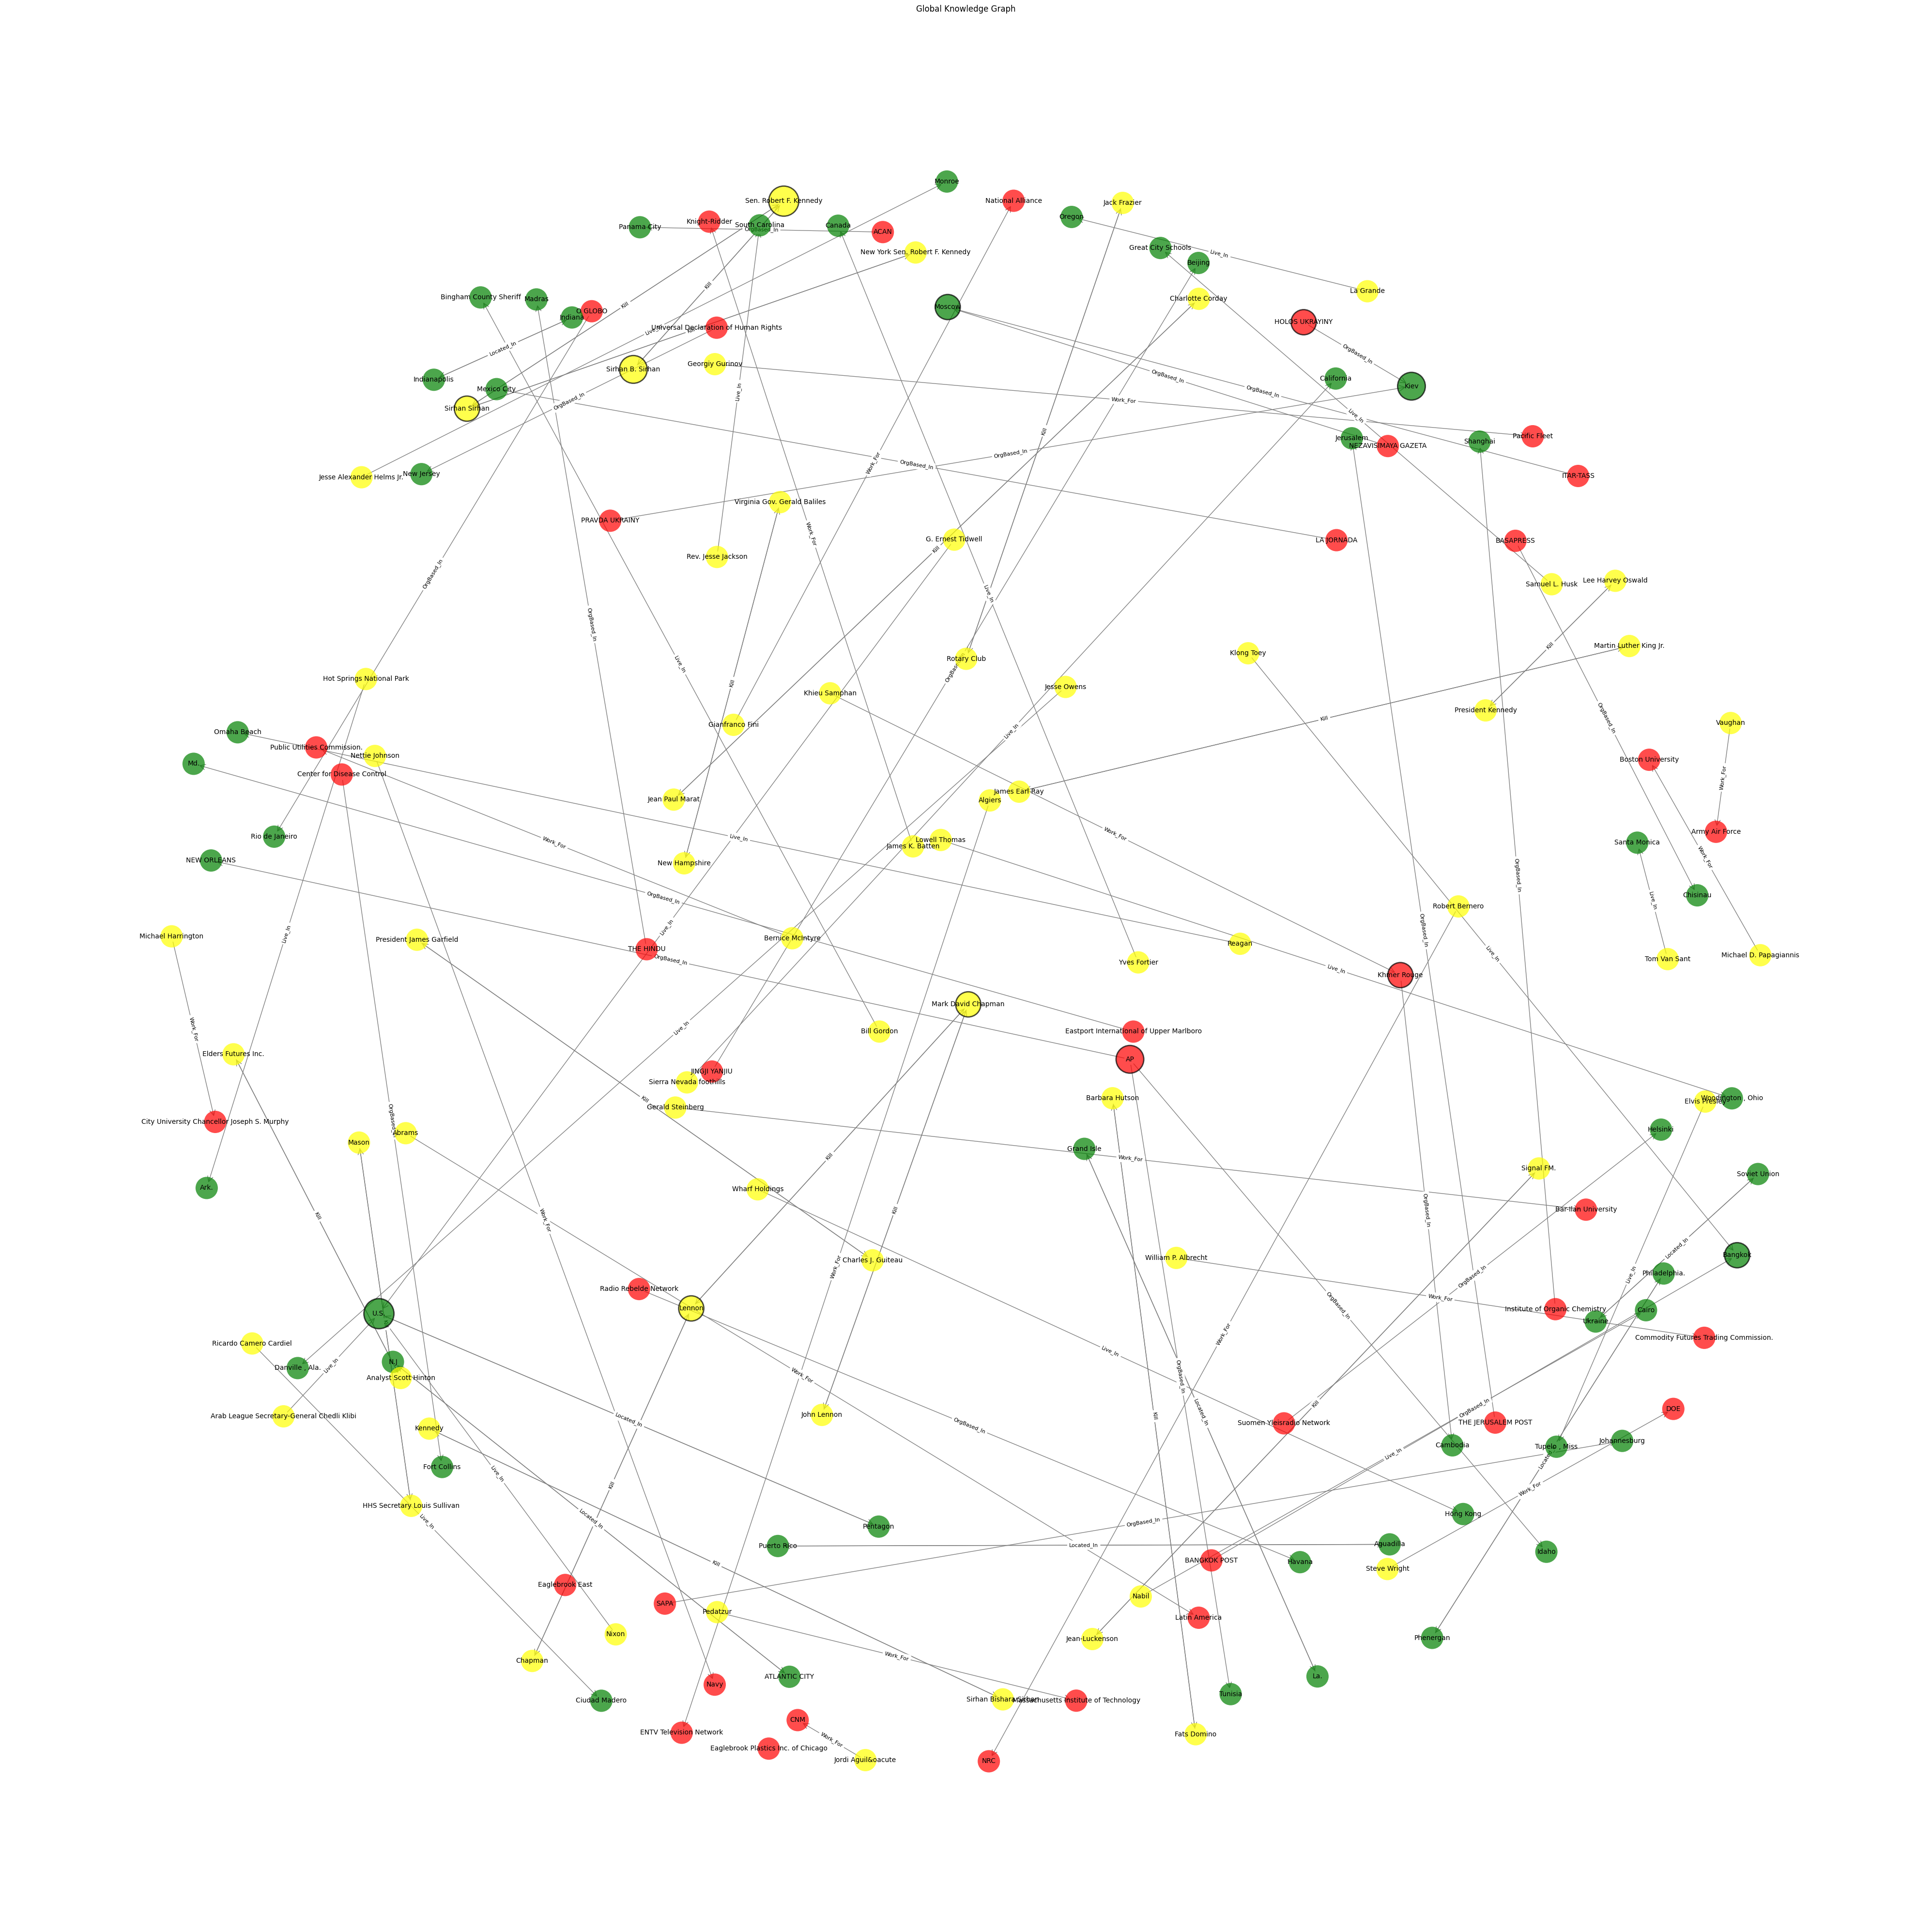

In [108]:
global_graph = build_global_knowledge_graph(df_croped_test)
visualize_global_knowledge_graph(global_graph)

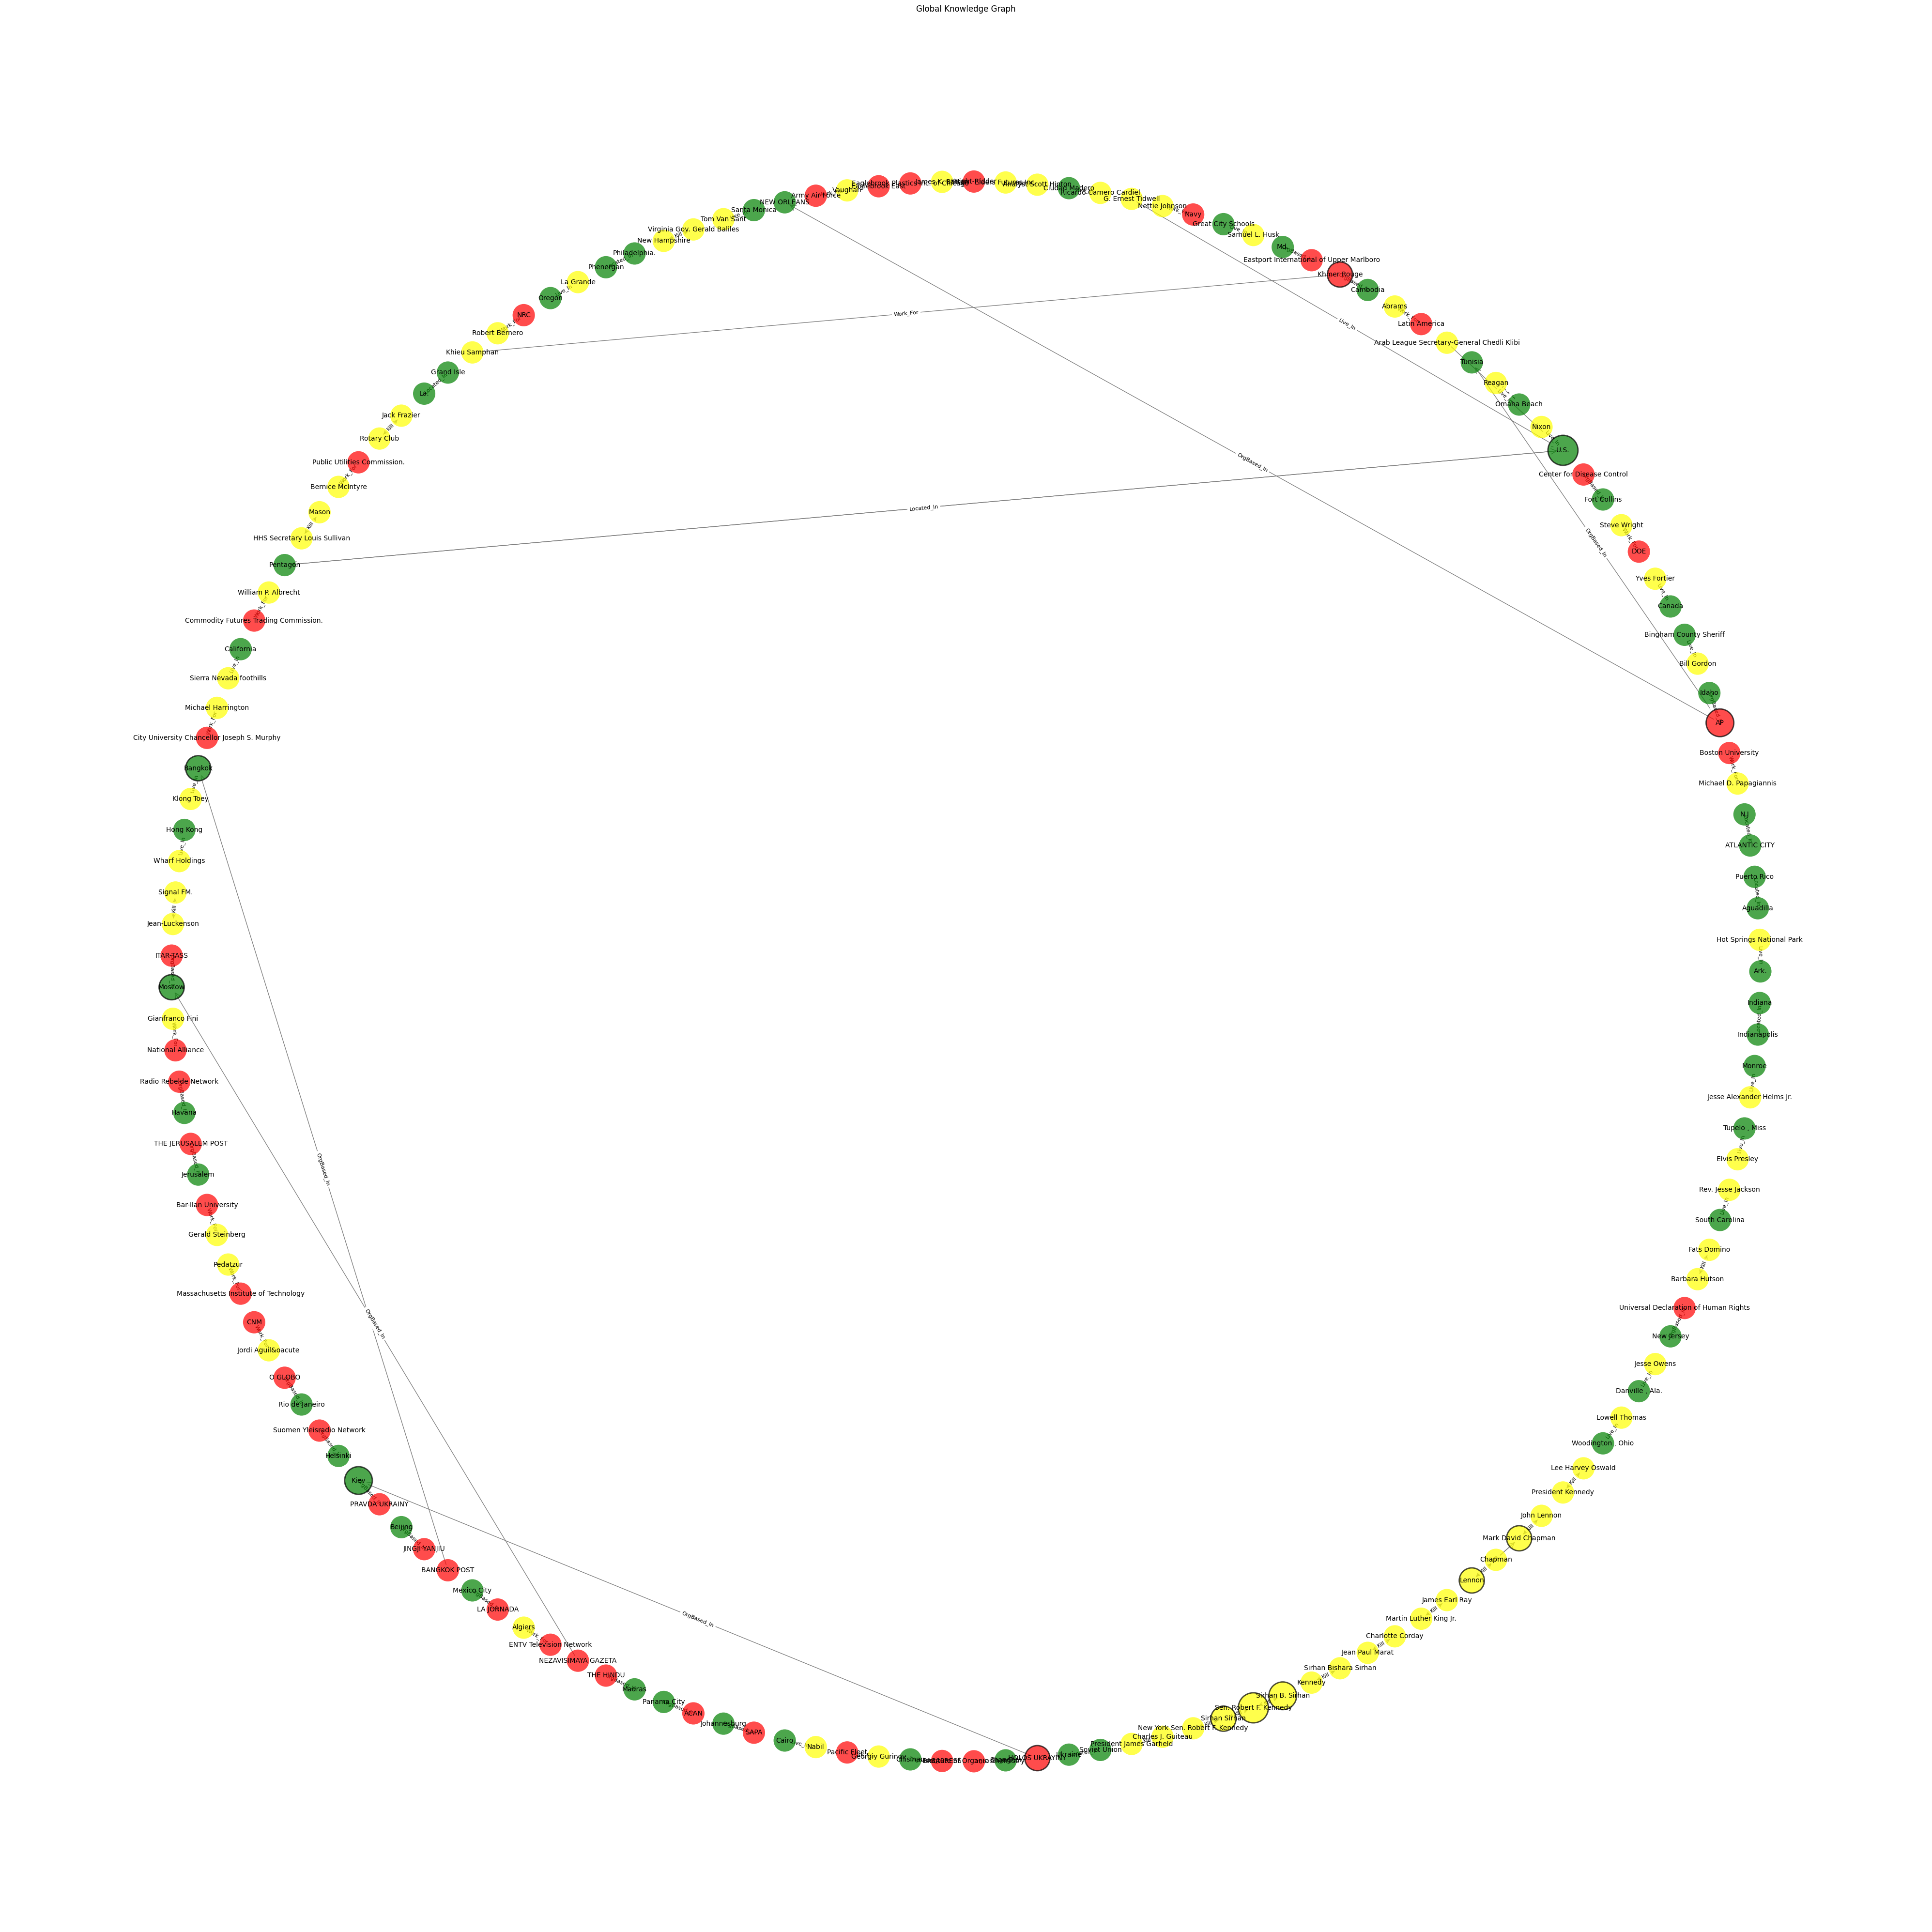

In [110]:
# circular_layout
global_graph = build_global_knowledge_graph(df_croped_test)
visualize_global_knowledge_graph(global_graph)